In [1]:
import sys
import scipy
import cv2 as cv
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from PIL import Image
import skimage as ski
import pytesseract

In [3]:
BORDER_GAP = 15 #
ECG_ROWS = 6
ECG_COLS = 2

## Functions

In [4]:
BLOCK_SIZE = 50
THRESHOLD = 25


def preprocess(image):
    image = cv.medianBlur(image, 3)
    image = cv.GaussianBlur(image, (3, 3), 0)
    return (image)

def invert_image(image):
    return (image-255)*255

def postprocess(image):
    #image = cv.medianBlur(image, 3)
    # image = cv2.medianBlur(image, 5)
    # kernel = numpy.ones((3,3), numpy.uint8)
    image = cv.morphologyEx(image, cv.MORPH_OPEN, (5,5),iterations=5)
    return image


def get_block_index(image_shape, yx, block_size): 
    y = np.arange(max(0, yx[0]-block_size[0]), min(image_shape[0], yx[0]+block_size[0]))
    x = np.arange(max(0, yx[1]-block_size[1]), min(image_shape[1], yx[1]+block_size)[1])
    return tuple(np.meshgrid(y, x))


def adaptive_median_threshold(img_in):
    med = np.median(img_in)
    img_out = np.zeros_like(img_in)
    img_out[img_in - med < THRESHOLD] = 255
    return img_out

def block_process_func(image, block_size):
    output =[]
    for row in range(0, image.shape[0], block_size[0]):
        for col in range(0, image.shape[1], block_size[1]):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_[block_idx] = adaptive_median_threshold(image[block_idx])

    return out_image

def block_image_process(image, block_size):
    out_image = np.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = adaptive_median_threshold(image[block_idx])

    return out_image


def process_image_file(filename):
    image_in = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY)

    image_in = preprocess(image_in)
    image_out = block_image_process(image_in, BLOCK_SIZE)
    image_out = postprocess(image_out)

    cv.imwrite('bin_' + filename, image_out)

def grid_removal(img):
    kernel = np.ones((10,10),np.uint8)
    dilation = cv.dilate(img,kernel,iterations = 1)
    return dilation

# Helper function to display segmented ECG picture
def display_segments(name, item, axis='off'):
    plt.figure(figsize=(12, 9))
    plt.imshow(item, cmap="magma")
    plt.title(name)
    plt.axis(axis)
    plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)
    plt.show()


def get_values(roi):
     '''
      get the values of coord x and y for the image that contain the signal
      INPUT:
            roi : binary image with signal in black
      OUTPUT:
            xs, ys: values of the signal
     '''
     length = roi.shape[1]
     width =  roi.shape[0]
     xs = []
     ys = []
     for j in range(length):
         for k in range(width - 1):
             if roi[k][j] == 0:
                xs.append(j)
                ys.append(width - k)
                break
             else:
                continue
     return width, length,xs,ys

def measure_extract_pulse(x,y, verbose=0):

    min_pulse = np.min(y)
    max_pulse = np.max(y)

    height = np.max(max_pulse-min_pulse)
    threshold = height / 2
    index = np.where((y - min_pulse)>=threshold)[0]
    width = x[index[-1]] - x[index[0]]
    if verbose == 1:
        print(f"pulse height: {height}")
        print(f"pulse width: {width} time units")
    return width, height

def get_pulse_mean(source_list):
    '''
    INPUT: List of tuples with width and height 

    OUTPUT: 
            w_mean:
            h_mean: 

    
    '''

    w_list, h_list = zip(*source_list)
    w_mean = np.nanmean(np.array(w_list))
    h_mean = np.nanmean(np.array(h_list))

    return w_mean, h_mean

def detect_ref_pulse(roi, template, threshold=0.6):
   
    w, h = template.shape[::-1]
    if roi.shape[0] <= template.shape[0] or roi.shape[1]<= template.shape[1]:
               
           #template is bigger then roi. Can not perform matchTemplate

            empty_list=[]
            empty_array = np.array(empty_list)
            loc = (empty_array,empty_array )
    else:
            res = cv.matchTemplate(roi,template,cv.TM_CCOEFF_NORMED) # try tofind the pulse using a template match
            #threshold = 0.75
            loc = np.where( res >= threshold)

    if len(loc[0])>0:
        detected = True # pulse was detected 

        ppts=np.array(list(map(list, zip(*loc[::-1])))) #obtain um array from the list of tuples
        ppts_max= ppts[:,0].max()
        ppts_min= ppts[:,0].min()
        ppts_median = np.median(ppts[:,0])
        print(ppts_max, ppts_median, ppts_min)
        extracted_pulse = roi[:,ppts_max:ppts_max+w]
        baseline_pulse = np.argmax(np.std(extracted_pulse, axis =1))
        _,_,xpulse,ypulse= get_values(extracted_pulse)
        wpulse,hpulse = measure_extract_pulse(xpulse,ypulse)
        # curve_scales.append((wpulse,hpulse))
             
        if (ppts_median > roi.shape[1]//2): 
                     #pulse detected on the right
                     print("detect on the right")
                     roi = roi[:,:-ppts_min]
        else:
                    #pulse detected on the left
                    print("detect on the left")
                    roi = roi[:,ppts_max+w+1:]
              
              
              
    else:
              # No pulse detected or the roi has no pulse
              detected = False
              #curve_scales.append((np.nan,np.nan))
              wpulse = np.nan
              hpulse = np.nan
    
    return detected, wpulse, hpulse, roi 

def get_rectangular_contours(contours):
    """Approximates provided contours and returns only those which have 4 vertices"""
    res = []
    for contour in contours:
        hull = cv.convexHull(contour)
        peri = cv.arcLength(hull, closed=True)
        approx = cv.approxPolyDP(hull, 0.04 * peri, closed=True)
        if len(approx) == 4:
            res.append(approx)
    return res
 
def py_blockproc(A, blockdims, func=0):
    vr, hr = A.shape[0] // blockdims[0], A.shape[1] // blockdims[1]
    B = np.zeros((vr,hr))
    print(B.shape)
    verts = np.vsplit(A, vr)
    for i in range(len(verts)):
       for j, v in enumerate(np.hsplit(verts[i], hr)):
          B[i,j]=(np.std(A[
             i * blockdims[0] : (i + 1) * blockdims[0],
             j * blockdims[1] : (j + 1) * blockdims[1]
            ]))
    return B

In [5]:
import numpy as np
import cv2 as cv

def laplacian_filter(img, kSize=3, gSize=3, alpha=1.):
    input_is_bgr = len(img.shape) == 3

    if input_is_bgr: 
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray_img = img
   
    # Gaussian blurring / low-pass filter.
    gauss = cv.GaussianBlur(gray_img, (gSize, gSize), 0.)

    # Edge detection / high-pass filter.
    lpl = cv.Laplacian(gauss, cv.CV_32F, ksize=kSize)
    if input_is_bgr: 
        lpl  = cv.cvtColor(lpl, cv.COLOR_GRAY2BGR)
     
    # Image sharpening.
    filtered_img = img.astype("float32") - alpha * lpl
    
    return np.clip(filtered_img, 0., 255.).astype("uint8")



## Calculations

An Image scanned in 600 dpi , each point represents 0.042 mm. If one scans an A4 sheet (210 mm x 297 mm ). If you translate in points 
is 5000 X 7071.

## Main Code

### Load Image

(1560, 2300, 3)


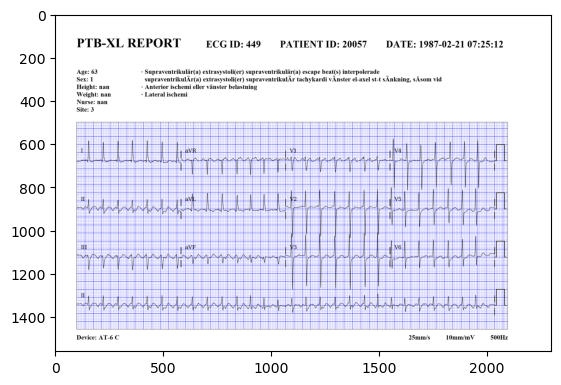

In [6]:
#image_name = 'images/test3.jpg'  # select image
image_name = 'images/ecg_test.png'  # select image
image = cv.imread(image_name)

# sanity check
if image is None:
    print('Cannot open image: ' + image_name)
    sys.exit(0)

plt.imshow(image, cmap="gray")
print(image.shape)
   



### Color Image

In [7]:
# get list of unique colors
list_bgr_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
print(list_bgr_colors)

[[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [253 253 253]
 [254 254 254]
 [255 255 255]]


In [8]:
#TODO  better upper selection

#### Filter Color

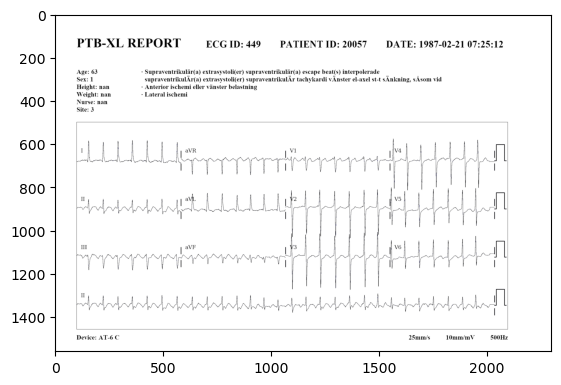

In [9]:
lower=(0,0,0) # black color
upper=(100,100,100) # dark gray
mask = cv.inRange(image, lower, upper)
result = image.copy()
result[mask!=255] = (255, 255, 255) # if it is not very dark set it to white

plt.imshow(result, cmap="gray")

(1560, 2300)

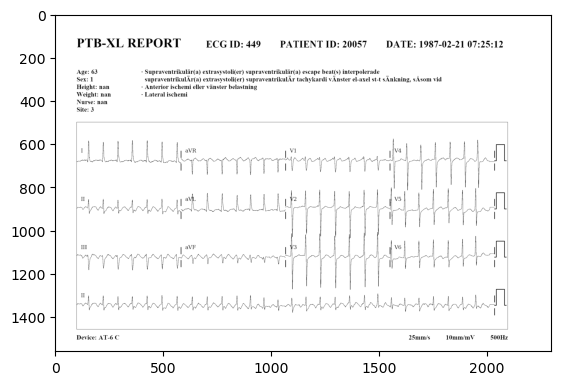

In [10]:
image_gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY )
plt.imshow(image_gray, cmap="gray")
image_gray.shape

### Gray Image

(1044, 1235, 3)


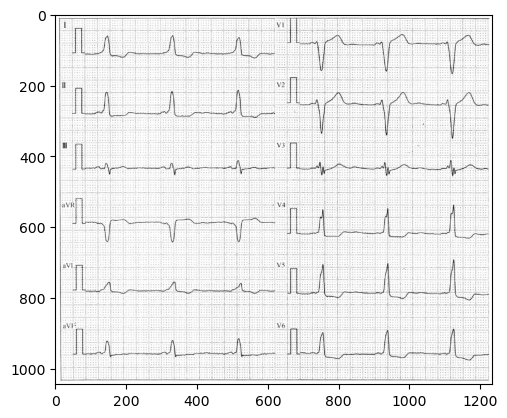

In [165]:
image_gray = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)  # read the image as GS

# sanity check
if image is None:
    print('Cannot open image: ' + image_name)
    sys.exit(0)

plt.imshow(image_gray,cmap="gray")
print(image.shape)

### Convert to Binary

(1560, 2300)


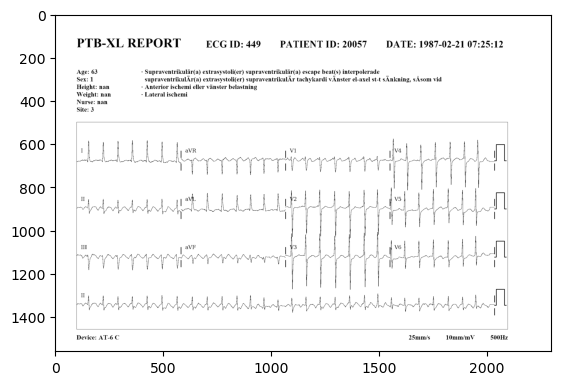

In [11]:
# use thresholding to transform the image into a binary one
ret, th1 = cv.threshold(image_gray, 127, 255,cv.THRESH_OTSU)
plt.imshow(th1, cmap="gray")
print(th1.shape)

### Image Recognition

Find the largest bouding box that contains the image

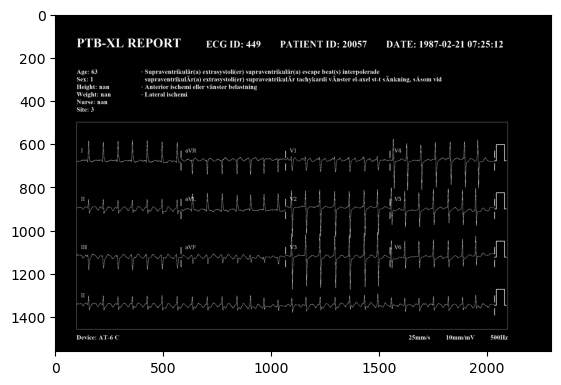

In [12]:
foreground  = 255-th1
contours, _ = cv.findContours(foreground, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
rectangular_contours = get_rectangular_contours(contours)
plt.imshow(foreground, cmap="gray")

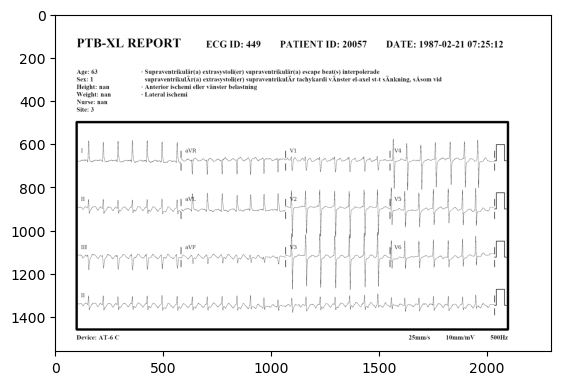

In [13]:
contour_image = image_gray.copy()

# find the biggest countour (c) by the area
c = max(contours, key = cv.contourArea)
x_border,y_border,w_border,h_border = cv.boundingRect(c)
# draw the biggest contour (c) in green
cv.rectangle(contour_image,(x_border,y_border),(x_border+w_border,y_border+h_border),(0,255,0),10)


plt.imshow(contour_image, cmap="gray")


### Crop the image

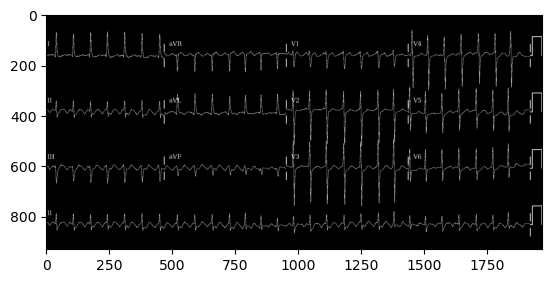

In [14]:
foreground  = 255-th1[y_border+BORDER_GAP:y_border+h_border-BORDER_GAP,
                      x_border+BORDER_GAP:x_border+w_border-BORDER_GAP]
plt.imshow(foreground, cmap = "gray")
plt.show()




### Find the lines

In [15]:
from scipy.signal import find_peaks
temp= py_blockproc(foreground,(1,foreground.shape[1]), func=0)
median_temp = np.median(temp.flatten())
peak_indices, peak_dict = find_peaks(temp.flatten(), height=median_temp, distance=20)


(930, 1)


In [16]:
peak_dict

{'peak_heights': array([47.52975887, 55.44213095, 91.36928426, 45.54892405, 44.86622971,
        48.16915743, 66.37516091, 54.90278361, 81.5765723 , 40.49454557,
        34.15493314, 60.02854458, 40.87896839, 80.15656258, 50.03031812,
        43.8193835 , 37.26053097, 49.41907632, 85.88537128])}

In [17]:
peak_heights = peak_dict['peak_heights']

highest_peak_index = peak_indices[np.argsort(peak_heights)]
#second_highest_peak_index = peak_indices[np.argpartition(peak_heights,-2)[-2]]


In [18]:
highest_peak_index

array([442, 758, 414, 585, 653, 206, 185,  89, 312, 808, 633, 373, 125,
       555, 349, 612, 393, 829, 161], dtype=int64)

In [19]:
highest_peak_index[-4:]

array([612, 393, 829, 161], dtype=int64)

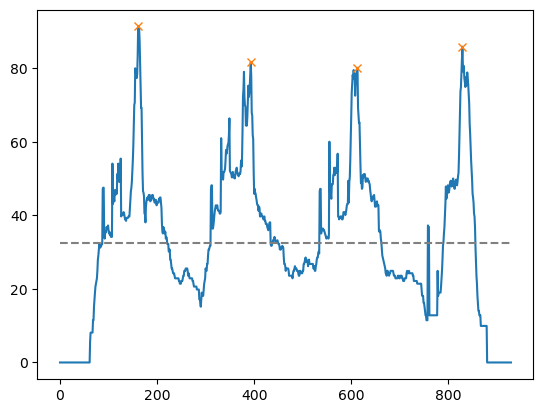

In [20]:
plt.plot(temp.flatten())
plt.plot(highest_peak_index[-4:], temp[highest_peak_index[-4:]], "x")
plt.plot(median_temp*np.ones_like(temp), "--", color="gray")
plt.show()

In [21]:
#Calculate the diference between the indice of the higjest peaks
ordered_hp_index = sorted(highest_peak_index[-4:])
print(ordered_hp_index)
index_diff = [np.abs(t - s) for s, t in zip(ordered_hp_index, ordered_hp_index[1:])]
max_diff = max(index_diff)//2 

[161, 393, 612, 829]


In [22]:
#cut the image according to the number of rows in the layout
#np.arange(max(0, yx[0]-block_size[0]), min(image_shape[0], yx[0]+block_size[0]))
slices_x = [(max(0, s-max_diff), min(foreground.shape[0],s+max_diff),None) for s in ordered_hp_index]
slices_y = [(0, foreground.shape[1], None) for s in ordered_hp_index]

In [24]:
slices_x, slices_y

([(45, 277, None), (277, 509, None), (496, 728, None), (713, 930, None)],
 [(0, 1970, None), (0, 1970, None), (0, 1970, None), (0, 1970, None)])

In [23]:
slices_x[0]

(45, 277, None)

INFO: Number of segments 20.


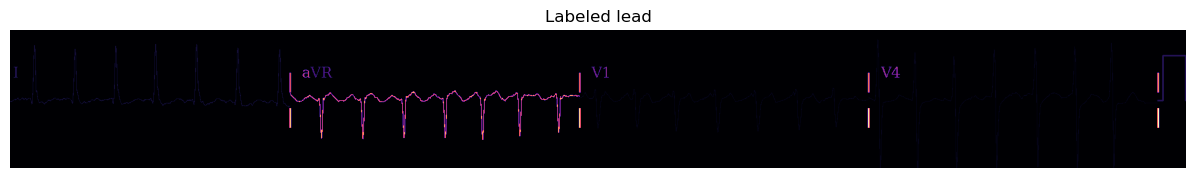

INFO: Number of segments 30.


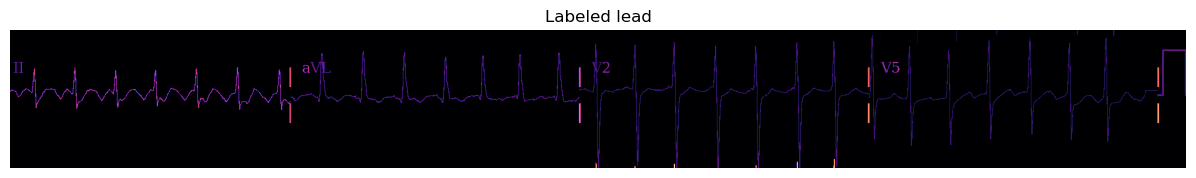

INFO: Number of segments 28.


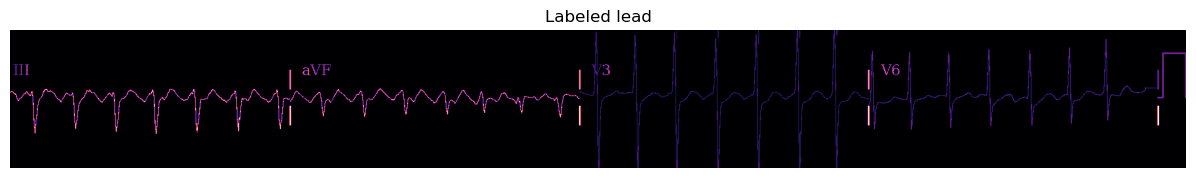

INFO: Number of segments 13.


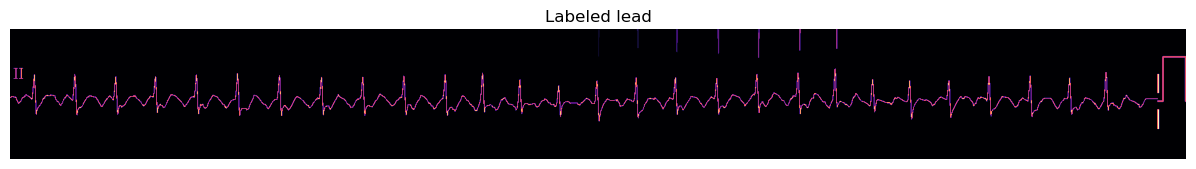

In [24]:
for i, slx in enumerate(slices_x): 
    lead = foreground[slice(*slx),slice(*(0, foreground.shape[1], None))]
    # plt.imshow(lead, cmap="gray")
    # plt.show()
    # segment lead using 

    structure = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], np.uint8)
    labeled_lead, nb = ndimage.label(lead, structure=structure)
    print("INFO: Number of segments {}.".format(nb))
    display_segments('Labeled lead', labeled_lead)
    u,c = np.unique(labeled_lead, return_counts=True) 
    segment_labels = np.argsort(c[1:])[-20:]+1

    
   

#### Complete Process

In [59]:



template_name = 'images/pulse.png'
template = cv.imread(template_name, cv.IMREAD_GRAYSCALE)
# sanity check
if image is None:
    print('Cannot open the template: ' + image_name)
    new_template = None
else:
 #load template to find the pulse
 _,new_template = cv.threshold(template,127,255,cv.THRESH_OTSU)


In [ ]:
def process_label(labeled_image, label, template):
    ''' 
    INPUT : labeled_image - segmented image
            label
            template
    '''
    sl = ndimage.find_objects(labeled_image==label)
    roi = labeled_image[sl[0][0],sl[0][1]] # slice in x and slice in y

    width = roi.shape[0]
    length = roi.shape[1]
    lb = sl[0][0].stop
    ub = sl[0][0].start

    

    roi_copy = roi.copy()
    roi_copy = np.where(roi_copy==label,0,255) # invert roi to use match template
    roi_copy = roi_copy.astype("uint8")

    detected, wpulse, hpulse, roi = detect_ref_pulse(roi_copy, template)
        

INFO: Curve 17 baseline = 0 line range = [177, 210].
INFO: Curve 32 baseline = 0 line range = [341, 374].
INFO: Curve 34 baseline = 0 line range = [341, 374].
INFO: Curve 6 baseline = 9 line range = [108, 126].
INFO: Curve 41 baseline = 74 line range = [535, 612].
INFO: Curve 60 baseline = 74 line range = [758, 835].
INFO: Curve 23 baseline = 75 line range = [311, 389].
INFO: Curve 3 baseline = 75 line range = [88, 166].
INFO: Curve 54 baseline = 18 line range = [595, 644].
INFO: Curve 55 baseline = 17 line range = [596, 671].
INFO: Curve 31 baseline = 38 line range = [341, 434].
INFO: Curve 16 baseline = 9 line range = [147, 230].
INFO: Curve 24 baseline = 79 line range = [314, 401].
INFO: Curve 2 baseline = 93 line range = [70, 176].
INFO: Curve 40 baseline = 94 line range = [513, 664].
INFO: Curve 21 baseline = 106 line range = [287, 472].
INFO: Curve 22 baseline = 82 line range = [297, 522].
INFO: Curve 39 baseline = 108 line range = [494, 761].
INFO: Curve 1 baseline = 99 line ran

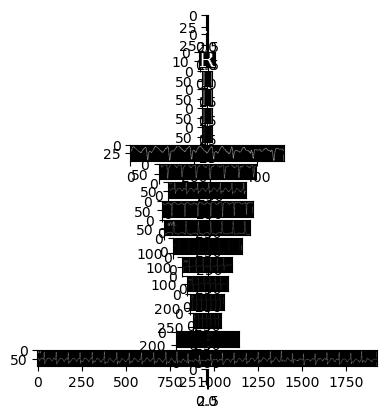

In [61]:
#TODO

u,c = np.unique(labeled_image, return_counts=True) 
curve_labels = np.argsort(c[1:])[-20:]+1




fig, axs = plt.subplots(len(curve_labels))

curve_signals =[]
curve_baselines = []
curve_lengths = []
curve_widths = []
curve_lower_bound = []
curve_upper_bound = []
curve_scales=[]
for i, label in enumerate(curve_labels):
        sl = ndimage.find_objects(labeled_image==label)
        roi = labeled_image[sl[0][0],sl[0][1]] # slice in x and slice in y
       
        axs[i-1].imshow(roi, cmap='gray')
        curve_widths.append(roi.shape[0])
        curve_lengths.append(roi.shape[1])
        curve_lower_bound.append(sl[0][0].stop)
        curve_upper_bound.append(sl[0][0].start)
      
       
        roi_copy = roi.copy()
        roi_copy = np.where(roi_copy==label,0,255) # invert roi to use match template
        roi_copy = roi_copy.astype("uint8")

        detected, wpulse, hpulse, roi = detect_ref_pulse(roi_copy, template)
        curve_scales.append((wpulse,hpulse))

        baseline = np.argmax(np.std(roi, axis =1)) # ECG baseline without reference pulse 
        curve_baselines.append(baseline)
        print("INFO: Curve {} baseline = {} line range = [{}, {}].".format(label,baseline, sl[0][0].start, sl[0][0].stop))
        
        #store the roi fro further extraction
        curve_signals. append(roi)
         
        

       

INFO: Rhythm Length: 1923.


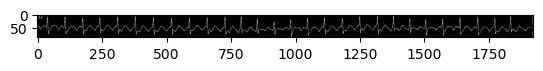

In [86]:

#find the largest signal
rhythm_index = np.argsort(curve_lengths)[-1] # get the last element
rhythm_label = curve_labels[rhythm_index]
slice_x, slice_y = ndimage.find_objects(labeled_image==rhythm_label)[0]
roi = labeled_image[slice_x,slice_y]
plt.imshow(roi,cmap = "gray")
rhythm_length = curve_lengths[rhythm_index]
print("INFO: Rhythm Length: {}.".format(rhythm_length))

    


In [77]:
layout=(3,4)
layout[0]

3

In [87]:
np.median(curve_lengths)

470.5

In [88]:
#Compare the the lengths of the other segments
import math
layout = (3,4)
app_seg_size = rhythm_length// layout[1]
segment_list=[]
print("INFO: Approximate Segment Size: {}.".format(app_seg_size))
for i, label in enumerate(curve_labels):
    if abs(curve_lengths[i] -app_seg_size ) <= (app_seg_size//10):
        # segment size correct
        print("INFO: Curve {} length = {} is correct.".format(label,curve_lengths[i]))
        segment_list.append(curve_lengths[i])
    else:
        # segment size incorrect
        print("INFO: Curve {} length = {} is wrong.".format(label,curve_lengths[i]))
        


INFO: Approximate Segment Size: 480.
INFO: Curve 17 length = 3 is wrong.
INFO: Curve 32 length = 3 is wrong.
INFO: Curve 34 length = 3 is wrong.
INFO: Curve 6 length = 18 is wrong.
INFO: Curve 41 length = 48 is wrong.
INFO: Curve 60 length = 48 is wrong.
INFO: Curve 23 length = 48 is wrong.
INFO: Curve 3 length = 48 is wrong.
INFO: Curve 54 length = 485 is correct.
INFO: Curve 55 length = 469 is correct.
INFO: Curve 31 length = 471 is correct.
INFO: Curve 16 length = 485 is correct.
INFO: Curve 24 length = 485 is correct.
INFO: Curve 2 length = 470 is correct.
INFO: Curve 40 length = 487 is correct.
INFO: Curve 21 length = 485 is correct.
INFO: Curve 22 length = 486 is correct.
INFO: Curve 39 length = 486 is correct.
INFO: Curve 1 length = 970 is wrong.
INFO: Curve 63 length = 1923 is wrong.


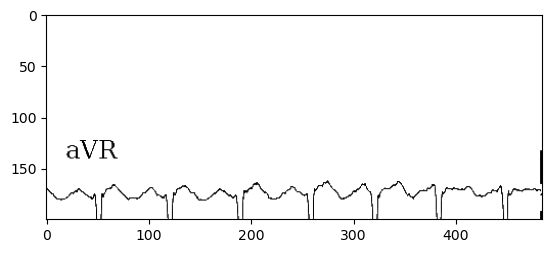

In [ ]:
m=1
k=485

plt.imshow(image_gray[500:700,(m*k)+100:((m+1)*k)+100], cmap="gray")
plt.show()

In [ ]:
import math
def is_nan(value):
    try:
        return math.isnan(float(value))
    except ValueError:
        return False
#get the mean of detected pulses
wmean, hmean = get_pulse_mean(curve_scales)

curve_signals_mv=[]
for i, label in enumerate(curve_labels):
    roi = curve_signals[i]
    ws,hs, xs,ys = get_values(roi)
    zero_line = ws-curve_baselines[i]
    h = curve_scales[i][1]
    if is_nan(h)==True: 
        #pulse was not detected. Use the mean value
        wp  = wmean
        hp  = hmean
    else:
        wp,hp = curve_scales[i]

    #convert to mv
    ymv = (ys-zero_line)/hp
    curve_signals_mv.append((xs,ymv))


In [25]:
# for i in range(len(curve_signals_mv)):
#     x = curve_signals_mv[i][0]
#     y=  curve_signals_mv[i][1]
#     plt.plot(x,y)
#     plt.show()

### Test for on curve

In [27]:
u,c = np.unique(labeled_lead, return_counts=True) 
curve_labels = np.argsort(c[1:])[-17:]+1
curve_labels

array([ 9, 10,  7,  2,  6, 12,  4,  3, 13,  1,  5,  8, 11], dtype=int64)

In [29]:
slice_x, slice_y = ndimage.find_objects(labeled_lead==11)[0]
#sl = ndimage.find_objects(labeled_image==19456)
slice_x, slice_y



(slice(66, 154, None), slice(0, 1923, None))

In [31]:
slice_x.start

66

(array([ 0, 51, 55, 56]), array([33348,     1,  1793,    33], dtype=int64))

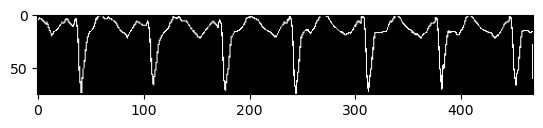

In [100]:
roi = labeled_image[slice_x,slice_y]
plt.imshow(roi,cmap = "gray")
u_roi,c_roi = np.unique(roi, return_counts=True) 

u_roi,c_roi

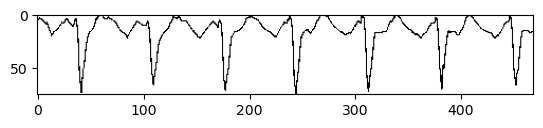

In [101]:

roi_copy = roi.copy()
roi_copy = np.where(roi_copy==55,0,255)
plt.imshow(roi_copy, cmap="gray")

In [102]:
roi_copy = roi_copy.astype("uint8")
roi_copy

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

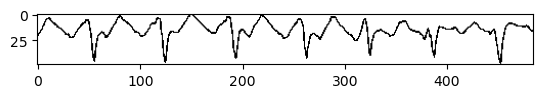

In [218]:
plt.imshow(roi_copy, cmap="gray")

In [103]:

template = cv.imread('images/pulse.png', cv.IMREAD_GRAYSCALE)
_,new_template = cv.threshold(template,127,255,cv.THRESH_OTSU)
w, h = template.shape[::-1]



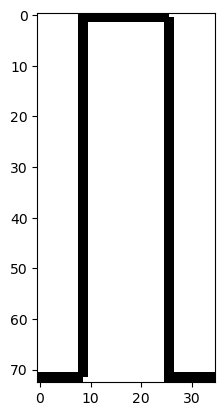

In [104]:
plt.imshow(new_template, cmap="gray")

In [105]:
res = cv.matchTemplate(roi_copy,new_template,cv.TM_CCOEFF_NORMED)
threshold = 0.6
loc = np.where( res >= threshold)

In [107]:
loc

(array([], dtype=int64), array([], dtype=int64))

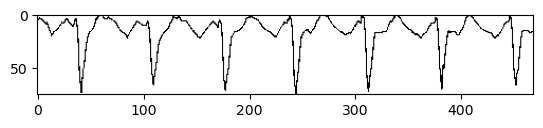

In [106]:
for pt in zip(*loc[::-1]):
    print(pt)
    #cv.rectangle(roi_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
 
cv.imwrite('res.png',roi_copy)
plt.imshow(roi_copy, cmap="gray")

In [108]:
#Find out where the pulse was detected


ppts=np.array(list(map(list, zip(*loc[::-1])))) #obtain um array from the list of tuples
ppts_max= ppts[:,0].max()
ppts_min= ppts[:,0].min()
ppts_median = np.median(ppts[:,0])
print(ppts_max, ppts_median, ppts_min)
extracted_pulse = roi_copy[:,ppts_max:ppts_max+w]
baseline_pulse = np.argmax(np.std(extracted_pulse, axis =1))

if (ppts_median > roi_copy.shape[1]//2):
    #pulse detected on the right
    print("detect on the right")
    roi_copy = roi_copy[:,:-ppts_min]
else:
    #pulse detected on the left
    print("detect on the left")
    roi_copy = roi_copy[:,ppts_max+w+1:]



#roi_copy[:,ppts_max:ppts_max+w]=0 # remove pulse from roi 
plt.imshow(roi_copy, cmap ="gray")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

pulse height: 71
pulse width: 23 unidades de tempo


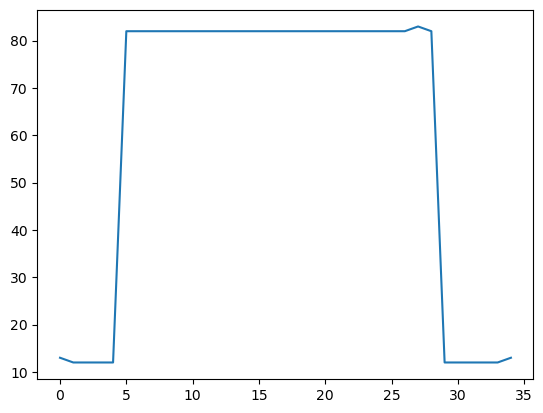

In [111]:
_,_, xp,yp = get_values(extracted_pulse)
plt.plot(xp,yp)

wp,hp = measure_extract_pulse(xp,yp,verbose=1)


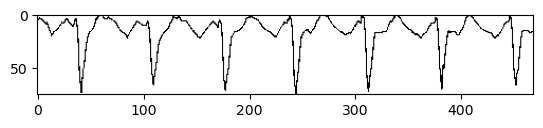

In [109]:
roi =roi_copy
plt.imshow(roi, cmap="gray")

17


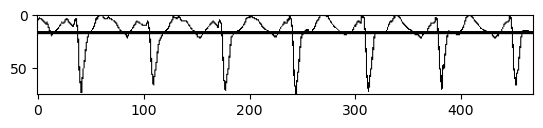

In [110]:
baseline = np.argmax(np.std(roi, axis =1))
print(baseline)
#draw a line
roi_copy = roi.copy()
line_thickness = 2
cv.line(roi_copy,(0,baseline),(roi.shape[1],baseline),color=1.0,thickness=line_thickness)
plt.imshow(roi_copy, cmap="gray")

In [79]:
np.argwhere(roi == 0)

array([[ 48, 246],
       [ 49,  62],
       [ 49,  63],
       ...,
       [ 82, 105],
       [ 82, 106],
       [ 82, 107]], dtype=int64)

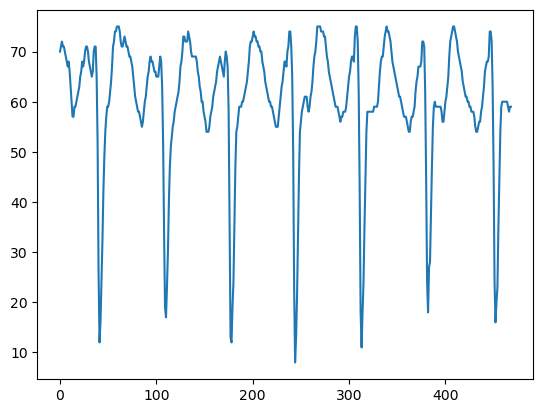

In [114]:
ws,hs, xs,ys = get_values(roi)
plt.plot(xs,ys)
plt.show()

In [120]:
slice_y

slice(0, 469, None)

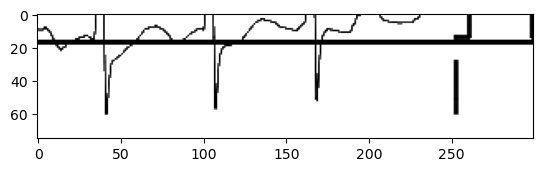

In [122]:
temp_image = image_gray[y_border+BORDER_GAP:y_border+h_border-BORDER_GAP,
                      x_border+BORDER_GAP:x_border+w_border-BORDER_GAP]
temp = temp_image[slice_x,-300:]
cv.line(temp,(0,baseline),(temp.shape[1],baseline),color=1.0,thickness=line_thickness)
plt.imshow(temp, cmap="gray")


In [ ]:
cv.line(temp,(0,baseline),(temp.shape[1],baseline),color=1.0,thickness=line_thickness)

In [112]:
zero_line = ws-baseline_pulse
zero_line

11

In [113]:
h

73

In [114]:
y = (ys-zero_line)/hp

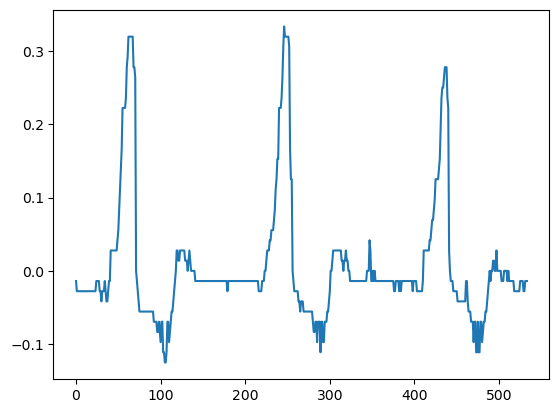

In [69]:
plt.plot(xs,y)